In [7]:
%matplotlib inline

In [8]:
import numpy as np
from math import *
from pylab import *
import random
import tensorflow as tf

In [9]:
batch_size = 256
num_iterations = 10000001

In [4]:
# def load_item_feature(LOAD_PATH):
#     D = {}
#     for i in range(25):
#         print i
#         x = np.load(LOAD_PATH % (i))
#         for key, val in x:
#             if key not in D:
#                 D[key] = []
#             D[key] += [val]
#     return D


In [5]:
# app_features = {}
# app_features = load_item_feature("tmp_app_install/feature-%d.npy")

In [6]:
# url_features = {}
# url_features = load_item_feature("tmp_url/feature-%d.npy")

In [ ]:
# query_features = {}
# query_features = load_item_feature("tmp_query/feature-%d.npy")

In [8]:
# def load_device_info():
#     D = {}
#     for i in range(2):
#         fn = "contest_dataset_app_device/device%06d_0" % i
#         with open(fn) as f:
#             for x in f:
#                 user_id, device_category, device_id = x.split()
#                 D[user_id] = device_id
#     return D

# device_features = load_device_info()

In [10]:
# get labels
def read_user_labels():
    user_labels = {}

    for fn in ['contest_dataset_label/label000000_0', 'contest_dataset_label/label000001_0']:
        with open(fn) as file_user_label:
            for x in file_user_label:
                user_id, gender, user_age = x.split()
                user_labels[user_id] = [int(gender) - 1, int(user_age) - 1]

    return user_labels

user_labels = read_user_labels()
print len(user_labels)

11439408


In [10]:
# def load_good_maps(good_path):
#     '''
#         Save/load good apps from file
#     '''
#     return np.load(good_path).item()

# good_url = load_good_maps("tmp_url/good.npy")
# good_app = load_good_maps("tmp_app_install/good.npy")
# good_query = load_good_maps("tmp_query/good.npy")
# # for i in range(REG_DIM):
# #     print good_gender_urls[i], np.sum(freq_gender[good_gender_urls[i][1]]), good_age_urls[i], np.sum(freq_age[good_age_urls[i][1]])

# # figure()
# # hist([x for x, y in gender_dists if x > 0.2], bins=40)
# # show()
# # print gender_dists[100]
# # print age_dists[100]
# # print log(7) / log(2) * 0.14591690295265844

In [11]:
import urllib2
import socket

ports = {'device': 4444, 'app': 5555, 'url': 6666, 'query': 7777}

def fetch_feature_by_http(dataset, mode, user_id):
    x = urllib2.urlopen("http://localhost:%d/query/%s/%s" % (ports[dataset], mode, user_id)).read()
    return np.fromstring(x, dtype=np.float32)

sockets = {}
for dataset, port in ports.items():
    print dataset
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect(("localhost", port))
    sockets[dataset] = s

def fetch_feature_by_socket(dataset, mode, user_id):
    sockets[dataset].sendall("%s %s" % (mode, user_id))
    data = sockets[dataset].recv(10000)
    return np.fromstring(data, dtype=np.float32)

def get_features(mode, user_id):
    Y = None
    if user_id in user_labels:
        Y = user_labels[user_id]
    for i in range(10):
        try:
#             X = np.hstack(
            X = \
                [
                    fetch_feature_by_socket('url', mode, user_id),
                    fetch_feature_by_socket('app', mode, user_id),
                    fetch_feature_by_socket('query', mode, user_id),
                    fetch_feature_by_socket('device', mode, user_id),
                ]
#             )
            break
        except:
            pass
    return X, Y

device
url
app
query


In [37]:
'''
define model
'''

NUM_UNITS = 200
RES_DEPTH = 18

def resblock(x):
    h = tf.contrib.layers.fully_connected(
        inputs=tf.contrib.layers.batch_norm(tf.nn.relu(x)),
        num_outputs=NUM_UNITS,
#         normalizer_fn=tf.contrib.layers.batch_norm,
#         activation_fn=tf.nn.relu,
    )
    y = tf.contrib.layers.fully_connected(
        inputs=tf.contrib.layers.batch_norm(tf.nn.relu(h)),
        num_outputs=NUM_UNITS,
#         normalizer_fn=tf.contrib.layers.batch_norm,
#         activation_fn=tf.nn.relu,
    )
    return x + y

def resnet(x, depth):
    res = tf.contrib.layers.fully_connected(
        inputs=x, # tf.nn.dropout(x, keep_rate),
        num_outputs=NUM_UNITS,
        normalizer_fn=tf.contrib.layers.batch_norm,
        activation_fn=tf.nn.relu,
    )

    for i in range(depth):
        res = resblock(res)
    return res

class Model:
    def __init__(self, sess, idim, odim, keep_rate, checkpoint_load, checkpoint_save):
        
        self.op_url = tf.placeholder(np.float32, [None, 1000])
        self.op_app = tf.placeholder(np.float32, [None, 1000])
        self.op_query = tf.placeholder(np.float32, [None, 1000])
        self.op_device = tf.placeholder(np.float32, [None, 250])

        self.op_Y = tf.placeholder(np.int32, [None])
        self.keep_rate = tf.constant(keep_rate)
        self.op_global_step = tf.Variable(1, trainable=False, name='global_step')
        self.op_learning_rate = tf.train.exponential_decay(1e-4, self.op_global_step, 5000, 0.9) + 1e-5

#         d = 4
#         res = tf.concat(1, [resnet(self.op_url, d), resnet(self.op_app, d), resnet(self.op_query, d), resnet(self.op_device, d)])
        res = tf.concat(1, [self.op_url, self.op_app, self.op_query, self.op_device])
#         res = tf.concat(1, [self.op_url, self.op_app, self.op_query, self.op_device])
        res = resnet(res, 4)
#         self.dying = tf.reduce_sum(tf.to_int32(tf.reduce_sum(tf.to_int32(res > 1e-6), 0) == 0))
        
        h2 = tf.contrib.layers.fully_connected(
            inputs=res, # tf.nn.dropout(h1, keep_rate),
            num_outputs=odim,
#             normalizer_fn=tf.contrib.layers.batch_norm,
#             activation_fn=tf.nn.relu,
        )
        self.logits = h2
        
#         regularization = tf.contrib.layers.apply_regularization(tf.contrib.layers.l1_regularizer(lambda_1)) + \
#             tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(lambda_2))
#         regularization = 0
        self.op_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits, self.op_Y))
        
        optimizer = tf.train.MomentumOptimizer(self.op_learning_rate, 0.9)
        grads_and_vars = optimizer.compute_gradients(self.op_loss)
        grads = [grad for grad, var in grads_and_vars]
        clipped_grads, global_norm = tf.clip_by_global_norm(grads, 10)

#         def clip_func(grad):
# #             return grad
#             return grad + tf.random_normal(tf.shape(grad), stddev=0.1 * tf.pow(tf.to_float(self.op_global_step), -0.55))

#         clipped_grads_and_vars = zip([clip_func(grad) for grad in clipped_grads], [var for grad, var in grads_and_vars])
#         self.op_train = optimizer.apply_gradients(clipped_grads_and_vars, global_step=self.op_global_step)
#         self.op_train = optimizer.minimize(self.op_loss, global_step=self.op_global_step)
        self.op_train = optimizer.apply_gradients(zip(clipped_grads, [var for grad, var in grads_and_vars]))

#         self.op_train = optimizer.minimize(self.op_loss) # no regularization due to dropout
        self.op_output = tf.nn.softmax(self.logits)
        self.odim = odim
        self.checkpoint_load = checkpoint_load
        self.checkpoint_save = checkpoint_save
        
        self.saver = tf.train.Saver()
        if checkpoint_load == None:
            sess.run(tf.initialize_all_variables())
        else:
            self.saver.restore(sess, self.checkpoint_load)
        self.history = []
    
    def train(self, sess, X, Y, loss=False, learning_rate=None):
        ops = [self.op_train, self.op_loss]
        url, app, query, device = X
        feed_dict = {
            self.op_url: url,
            self.op_app: app,
            self.op_query: query,
            self.op_device: device,
            self.op_Y: Y,
        }
        if learning_rate != None:
            feed_dict[self.op_learning_rate] = learning_rate
        
        ans = sess.run(
            ops,
            feed_dict=feed_dict,
        )
        self.history += [ans[1]]
        if len(self.history) % 1000 == 0:
            self.saver.save(sess, self.checkpoint_save, self.op_global_step)
        return ans[1:]
    
    def predict(self, sess, X):
        return sess.run(
            self.op_output,
            feed_dict={
                self.op_X: X,
                self.keep_rate: 1,
            }
        )
    
    def plot(self):
        figure()
        b = len(self.history) // 300 + 1
        n = len(self.history) // b * b
        x = np.mean(np.array(self.history[:n]).reshape((-1, b)), axis=1)
        plot(np.arange(len(x)) * b, np.minimum(x, log(self.odim)))
        show()


In [38]:
tf.reset_default_graph()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
# model_age = Model(sess, 3250, 7, 1., None, "model-age-2")

In [ ]:
model_gender = Model(sess, 3250, 2, 1., None, "model-gender-2")

In [ ]:
'''
train
'''

user_ids = user_labels.keys()
def train(model, mode):
    X = []
    Y = np.zeros((batch_size,), dtype=np.int32)

    for i in xrange(batch_size):
        user_id = random.sample(user_ids, 1)[0]
        x, (gender, age) = get_features(mode, user_id)
        X += [x]
        if mode == 'gender':
            Y[i] = gender
        else:
            Y[i] = age
#     X = np.vstack(X)
    X = [np.vstack([x[y] for x in X]) for y in range(4)]

    has_loss = T % 100 == 0
    loss = model.train(sess, X, Y, has_loss, learning_rate=1e-3)
    if has_loss:
        print "(mode = %s) #%d: loss = %.6f" % (mode, T, loss[0])

for T in xrange(num_iterations):
    train(model_gender, 'gender')
    #train(model_age, '                                            age')

(mode = gender) #0: loss = 123085136.000000
(mode = gender) #100: loss = 111810192.000000
(mode = gender) #200: loss = 126407600.000000


In [152]:
tf.train.global_step(sess, model_age.op_global_step)

1

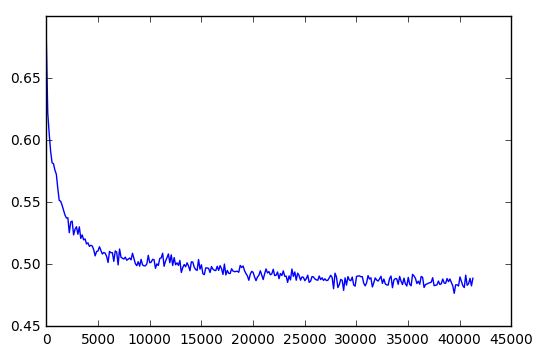

In [45]:
#model_age.plot()
model_gender.plot()
# print sum(model_age.history[-100:]) / 100

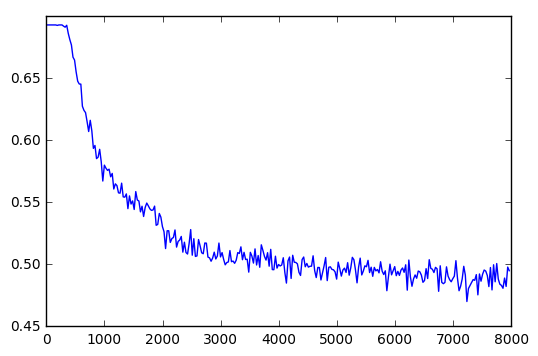

In [136]:
model_gender.plot()

model_gender.plot()

In [218]:
'''
The function which tries to predict a user.
'''

def model_predict(model, sess, X):
    url, app, query, device = X
    feed_dict = {
        model.op_url: url,
        model.op_app: app,
        model.op_query: query,
        model.op_device: device,
    }
    return sess.run(
        model.op_output,
        feed_dict=feed_dict
    )
    

def predict(mode, batch):
#     cur_gender, cur_age = np.zeros(2), np.zeros(7) # all_gender / sum(all_gender), all_age / sum(all_age)
    n = len(batch)
    X = []
    
    for i, user_id in enumerate(batch):
        x, _ = get_features(mode, user_id)
        X += [x]
#     X = np.vstack(X)
    X = [np.vstack([x[y] for x in X]) for y in range(4)]
    if mode == 'gender':
        return model_predict(model_gender, sess, X)
    return model_predict(model_age, sess, X)


In [219]:
# load testset data

testset = []
with open('contest_testset/testset000000_0') as file_test:
    for x in file_test.readlines():
        testset += [x[:-1]]

freqs = np.load("all_dist.npy").item()
all_gender = freqs['gender']
all_age = freqs['age']
 

In [124]:
'''
write a new CSV.
'''

D = []
xxx = 0

def test(predict, filename):
    with open(filename, 'w') as fout:
        print >> fout, 'user_id,gender_1,gender_2,age_g1,age_g2,age_g3,age_g4,age_5,age_g6,age_7'
        cnt = 0
        B = 128
        for b in range((len(testset) + B - 1) // (B)):
            current_batch = testset[b * B:(b + 1) * B]

#             pred_gender = predict('gender', current_batch)
            pred_gender = np.ones([len(current_batch), 2])
            pred_age = predict('age', current_batch)
            for i, user_id in enumerate(current_batch):
                cnt += 1
                if cnt % 10000 == 0:
                    print cnt
            
                cur_gender, cur_age = pred_gender[i], pred_age[i]

                print >> fout, '%s,%.9f,%.9f,%.9f,%.9f,%.9f,%.9f,%.9f,%.9f,%.9f' % (user_id, cur_gender[0], cur_gender[1], cur_age[0], cur_age[1], cur_age[2], cur_age[3], cur_age[4], cur_age[5], cur_age[6])

test(predict, 'CloudPlatform_1009_2.csv')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000


In [228]:
'''
Cross validation on devset.
'''

def cross_validate(devset):
    loss_age, loss_gender = 0., 0.
    
    cnt = 0
    
    B = 128
    for b in range((len(devset) + B - 1) // (B)):
        current_batch = devset[b * B:(b + 1) * B]
        
        #pred_age = predict('age', current_batch)
        pred_gender = predict('gender', current_batch)
        for i, user_id in enumerate(current_batch):
            cnt += 1
            gender, age = user_labels[user_id]
            #loss_age -= log(pred_age[i][age] + 1e-10)
            loss_gender -= log(pred_gender[i][gender] + 1e-10)
            if cnt % 10000 == 0:
                print cnt

#    loss_age /= len(devset)
    loss_gender /= len(devset)
    print 'loss: gender = %.6f' % (loss_gender)
#    print 'loss: age = %.6f' % (loss_age)

devset = random.sample(user_labels.keys(), 100000)
cross_validate(devset)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
loss: gender = 0.469789


In [22]:
useful = 0
for i, user_id in enumerate(testset): # enumerate(testset.iterkeys()):
    if np.sum(get_features('age', user_id)[0][:3000]) != 0:
        useful += 1
    if i % 10000 == 0:
#     else:
        print i + 1, useful, user_id

1 0 ec87fa14f5ffbd1796c2d91d2fbede11
10001 8709 3c91267ccd7c5baa9d73a8ca751d5901
20001 17439 1c8e5cf3b5207ee2d33af40d588c0824
30001 26152 3d4a6dc19e5d211f11dbafa6691deb61
40001 34830 2496b5aa7fd6239243af8b12645320b0
50001 43545 f00459d4009247f914498a5adb3df858
60001 52253 39a55dbd69d646df20196a40cf64b8fe
70001 61012 5185a60762201ed3869726a14a0920f0
80001 69691 aa04a92aa6d4d0f635143b9ac84e0e82
90001 78433 30d22dd7da7d2710435f37130d379885


KeyboardInterrupt: 

In [9]:
for i in range(10000):
    x = get_features("gender", "8b46164d7f9860c1981a5f157a114cee")

In [122]:
for op in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print op.name

fully_connected/weights:0
fully_connected/biases:0
fully_connected_1/weights:0
fully_connected_1/biases:0
fully_connected_2/weights:0
fully_connected_2/biases:0
fully_connected_3/weights:0
fully_connected_3/biases:0
fully_connected_4/weights:0
fully_connected_4/biases:0
fully_connected_5/weights:0
fully_connected_5/biases:0
fully_connected_6/weights:0
fully_connected_6/biases:0
fully_connected_7/weights:0
fully_connected_7/biases:0
fully_connected_8/weights:0
fully_connected_8/biases:0
fully_connected_9/weights:0
fully_connected_9/biases:0
fully_connected_10/weights:0
fully_connected_10/biases:0
fully_connected_11/weights:0
fully_connected_11/biases:0


In [118]:
x = sess.run("fully_connected/weights:0")

In [117]:
np.where(abs(x) < 1e-4)

(array([ 205,  460,  799, 1175, 1292, 1306, 1490, 1808, 1860, 1945, 2465,
        2818, 2832, 3054]), array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]))

In [120]:
np.where(abs(x) < 1e-4)

(array([ 632,  653,  723,  871,  929, 1063, 1338, 1425, 1588, 1636, 2102,
        2175, 2395]), array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]))